In [1]:
import torch
import wandb, os, json
import time
import numpy as np
from torch.amp import autocast, GradScaler, autocast_mode
import gc

from muon import Muon
from brainbert_model_model import GranularModel, LinearBinTransformer, BinTransformer, LinearKernelTransformer, FFTaker, BrainBERT
from model_electrode_embedding import ElectrodeEmbedding_Learned, ElectrodeEmbedding_NoisyCoordinate, ElectrodeEmbedding_Learned_CoordinateInit
from dataset import load_dataloaders, load_subjects
from brainbert_evaluation_neuroprobe import FrozenModelEvaluation_SS_SM
from brainbert_train_utils import log, update_dir_name, update_random_seed, convert_dtypes, parse_configs_from_args, get_default_configs, get_shared_memory_info
from torch.optim.lr_scheduler import ChainedScheduler


training_config, model_config, cluster_config = get_default_configs(random_string="MGH1", wandb_project="")
update_random_seed(training_config)

# Update model config settings
model_config['max_n_electrodes'] = 20
model_config['electrode_embedding']['spectrogram'] = True
model_config['bin_encoder'] = "transformer"
model_config['separate_unembed'] = True
model_config['first_kernel'] = 256
model_config['transformer']['n_layers_electrode'] = 6
model_config['transformer']['d_model_bin'] = 384
model_config['transformer']['causal'] = False
model_config['init_identity'] = False

# Update training config settings
training_config['weight_decay'] = 0.0
training_config['loss_type'] = "contrastive" # or "l2"
training_config['lr_schedule'] = "linear"
training_config['warmup_steps'] = 100
training_config['future_bin_idx'] = 0
training_config['use_temperature_param'] = True
training_config['p_show_a_embedding'] = 0.0
training_config['p_show_b_embedding'] = 1.0
training_config['p_masked_timebins'] = 0.2
training_config['max_temperature_param'] = 1000.0
training_config['batch_size'] = 256

training_config['train_subject_trials'] = [("mgh14", 0)]
training_config['eval_subject_trials'] = ""

cluster_config['cache_subjects'] = False

dir_name = update_dir_name(model_config, training_config, cluster_config)
cluster_config['wandb_name'] = cluster_config['dir_name']
log(f"Directory name: {dir_name}", priority=0)

if len(cluster_config['wandb_project'])==0: wandb = False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
log(f"Using device: {device}", priority=0)

log(f"Loading subjects...", priority=0)
all_subjects = load_subjects(training_config['train_subject_trials'], training_config['eval_subject_trials'], training_config['data_dtype'], 
                             cache=cluster_config['cache_subjects'], allow_corrupted=False)

n_downsample_factor = 1
assert n_downsample_factor == 1, "n_downsample_factor must be 1, not supported in the LinearBinTransformer class yet."

log(f"Loading model...", priority=0)
if model_config['electrode_embedding']['spectrogram']:
    bin_embed_transformer = FFTaker(
        d_input=model_config['first_kernel'],
        d_model=model_config['transformer']['d_model'],
        max_frequency=model_config['max_frequency']
    )
else:
    bin_embed_transformer = torch.nn.Identity()
    
if model_config['electrode_embedding']['spectrogram']:
    bin_unembed_transformer = FFTaker(
        d_input=model_config['first_kernel'],
        d_model=model_config['transformer']['d_model'],
        max_frequency=model_config['max_frequency'],
        output_transform=model_config['separate_unembed']
    )
else:
    bin_unembed_transformer = torch.nn.Identity() if not model_config['separate_unembed'] else LinearKernelTransformer(
                                                                                                    d_input=model_config['first_kernel'],
                                                                                                    d_output=model_config['transformer']['d_model'],
                                                                                                )
    
bin_unembed_transformer = bin_unembed_transformer.to(device, dtype=model_config['dtype'])
bin_embed_transformer = bin_embed_transformer.to(device, dtype=model_config['dtype'])

brainbert_d_input = model_config['first_kernel'] if not model_config['electrode_embedding']['spectrogram'] else 40 # XXX hardcoded max frequency bin
model = BrainBERT(
    d_input=brainbert_d_input,
    d_model=model_config['transformer']['d_model'],
    d_output=model_config['transformer']['d_model'] if model_config['separate_unembed'] else brainbert_d_input,
    n_layers=model_config['transformer']['n_layers_electrode'],
    n_heads=model_config['transformer']['n_heads'],
    dropout=model_config['transformer']['dropout']
).to(device, dtype=model_config['dtype'])

if model_config['electrode_embedding']['type'] == 'learned' or model_config['electrode_embedding']['type'] == 'zero':
    electrode_embeddings = ElectrodeEmbedding_Learned(
        model_config['transformer']['d_model'], 
        embedding_dim=model_config['electrode_embedding']['embedding_dim'],
        embedding_requires_grad=model_config['electrode_embedding']['type'] != 'zero'
    )
elif model_config['electrode_embedding']['type'] == 'coordinate_init':
    electrode_embeddings = ElectrodeEmbedding_Learned_CoordinateInit(
        model_config['transformer']['d_model'], 
        embedding_dim=model_config['electrode_embedding']['embedding_dim']
    )
elif model_config['electrode_embedding']['type'] == 'noisy_coordinate':
    electrode_embeddings = ElectrodeEmbedding_NoisyCoordinate(
        model_config['transformer']['d_model'], 
        coordinate_noise_std=model_config['electrode_embedding']['coordinate_noise_std'],
        embedding_dim=model_config['electrode_embedding']['embedding_dim']
    )
else:
    raise ValueError(f"Invalid electrode embedding type: {model_config['electrode_embedding']['type']}")
electrode_embeddings = electrode_embeddings.to(device, dtype=model_config['dtype'])

for subject in all_subjects.values():
    #subject.set_electrode_subset(['T1cIe11'])
    log(f"Adding subject {subject.subject_identifier} to electrode embeddings...", priority=0)
    this_subject_trials = [trial_id for (sub_id, trial_id) in training_config['train_subject_trials'] if sub_id == subject.subject_identifier]
    electrode_embeddings.add_subject(subject)
electrode_embeddings = electrode_embeddings.to(device, dtype=model_config['dtype']) # moving to device again to ensure the new parameters are on the correct device


[14:44:39 gpu 0.0G ram 0.5G] Directory name: M_nst1_dm192_dmb384_nh12_nl6_5_nes20_nf_beT_nII_pmt0.2_SU_eeL_bs256_fk256_rMGH1
[14:44:40 gpu 0.0G ram 0.5G] Using device: cuda
[14:44:40 gpu 0.0G ram 0.5G] Loading subjects...
[14:44:40 gpu 0.0G ram 0.5G]     loading subject mgh14...
[14:44:40 gpu 0.0G ram 0.5G] Loading model...
[14:44:48 gpu 0.0G ram 0.7G] Adding subject mgh14 to electrode embeddings...


In [9]:
epoch_number = 0
# Load saved model checkpoint
model_path = f"models_data/{dir_name}/model_epoch_{epoch_number}.pth"
checkpoint = torch.load(model_path)

# Load model state dicts
model.load_state_dict(checkpoint['model_state_dict'])
bin_embed_transformer.load_state_dict(checkpoint['bin_embed_transformer_state_dict'])
bin_unembed_transformer.load_state_dict(checkpoint['bin_unembed_transformer_state_dict']) 
electrode_embeddings.load_state_dict(checkpoint['electrode_embeddings_state_dict'])

<All keys matched successfully>

In [10]:
from evaluation_mgh_seizure import MGHSeizureDataset
from subject_mgh import MGHSubject
subject_id, session_id = 14, 0
subject = all_subjects[f"mgh{subject_id}"]
dataset = MGHSeizureDataset(subject, session_id, WINDOW_SIZE=1, SEIZURE_REGION_SIZE=10)
print(len(dataset))
print(dataset[0][0].shape, dataset[0][1])

254
torch.Size([162, 1024]) 0


In [11]:
batch_input = []
batch_label = []
n_skip_over_items = 1 # has to be odd so that both 1 and 0 labels are represented
for i in range(0, len(dataset), n_skip_over_items):
    batch_input.append(dataset[i][0].unsqueeze(0).to(device, dtype=model_config['dtype']))
    batch_label.append(dataset[i][1])
batch_input = torch.cat(batch_input, dim=0) # shape (batch_size, n_electrodes, n_samples)
batch_label = torch.tensor(batch_label) # shape (batch_size)

electrode_subset = ['LHH13', 'LAMY1', 'LHT11', 'LFId2', 'LFIb5', 'LTSb2', 'LHH10', 'LFIc9']
electrode_indices = [subject.electrode_labels.index(electrode) for electrode in electrode_subset]

print(batch_label)

model.eval()
bin_embed_transformer.eval()

with torch.no_grad():
    electrode_data = bin_embed_transformer(batch_input) # shape (batch_size, n_electrodes, n_timebins, frequency_bins)
    batch_size, n_electrodes, n_timebins, frequency_bins = electrode_data.shape

    #embeddings = electrode_embeddings.forward(electrode_indices)
    features = model.generate_frozen_evaluation_features(electrode_data, None, feature_aggregation_method="concat").reshape(batch_size, n_electrodes, n_timebins, -1)
    features = features.mean(dim=2) # shape (batch_size, n_electrodes, d_model)

batch_label = batch_label.unsqueeze(1).repeat(1, len(electrode_indices))
features = features[:, electrode_indices]
print(batch_label.shape, features.shape)

tensor([0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
        0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
        0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
        0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
        0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
        0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
        0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
        0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
        0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
        0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
        0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1])
torch.Size([254, 8]) torch.Size([254, 8, 192])


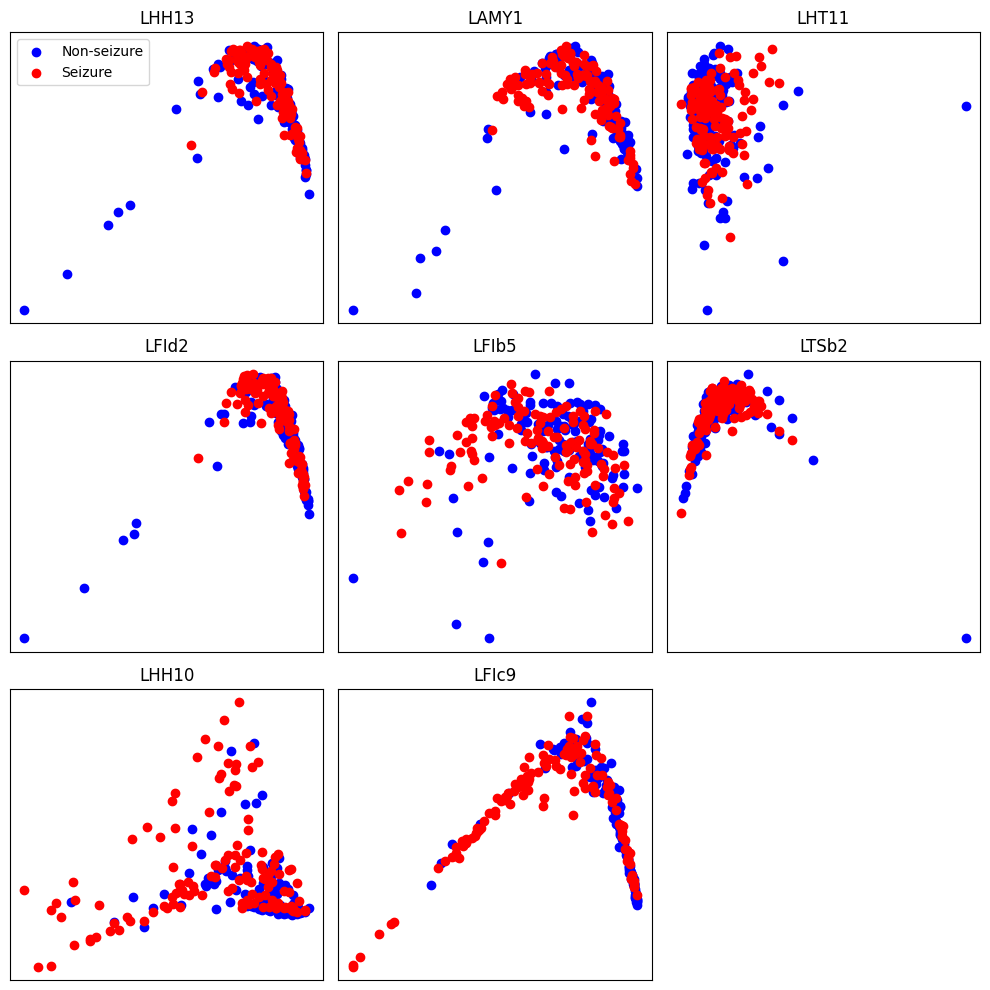

In [12]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
# Calculate number of rows/cols needed for roughly square grid
n_electrodes = features.shape[1]
grid_size = int(np.ceil(np.sqrt(n_electrodes)))

# Create subplot grid
fig, axes = plt.subplots(grid_size, grid_size, figsize=(10,10))
axes = axes.flatten()

# For each electrode
for electrode_i in range(n_electrodes):
    # Get features for this electrode
    electrode_features = features[:, electrode_i, :]  # shape: (batch_size, d_model)
    electrode_labels = batch_label[:, electrode_i]    # shape: (batch_size)
    
    # Fit and transform PCA
    pca = PCA(n_components=2)
    features_2d = pca.fit_transform(electrode_features.cpu().detach().numpy())
    
    # Plot points colored by label
    for label in [0, 1]:
        mask = electrode_labels.cpu() == label
        color = 'blue' if label == 0 else 'red'
        label_str = 'Seizure' if label == 1 else 'Non-seizure'
        axes[electrode_i].scatter(features_2d[mask, 0], features_2d[mask, 1],
                                c=color, label=label_str)
    
    electrode_label = subject.electrode_labels[electrode_indices[electrode_i]]
    axes[electrode_i].set_title(f'{electrode_label}')
    # axes[electrode_i].set_xlabel('PC1')
    # axes[electrode_i].set_ylabel('PC2')
    axes[electrode_i].set_xticks([])
    axes[electrode_i].set_yticks([])

    if electrode_i == 0:
        axes[electrode_i].legend()

# Hide empty subplots
for i in range(n_electrodes, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()


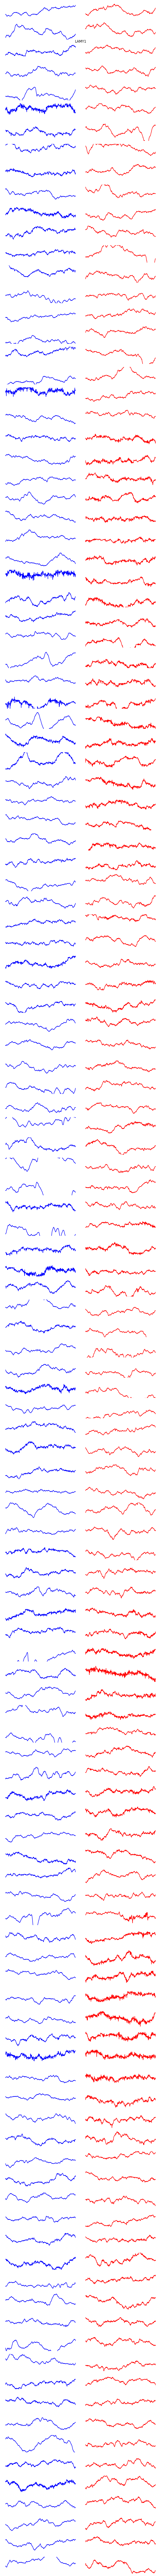

In [8]:
electrode_label = "LAMY1"
electrode_i = electrode_subset.index(electrode_label)

ylim_scale = 0.0002

label_0_indices = np.where(batch_label[:, electrode_i] == 0)[0]#[::5]
label_1_indices = np.where(batch_label[:, electrode_i] == 1)[0]#[::5]

batch_input_electrode = batch_input[:, electrode_i] # shape (batch_size, n_timebins)

# Plot half of the samples
n_samples = batch_input_electrode.shape[0] // 2

# Calculate number of rows needed
n_rows = max(len(label_0_indices[:n_samples]), len(label_1_indices[:n_samples]))
# Create figure with subplots - 2 columns, one for each label
fig, axes = plt.subplots(n_rows, 2, figsize=(8, 1*n_rows))
ax_left = axes[:, 0]  # Left column
ax_right = axes[:, 1] # Right column

# Plot label 0 samples in left column
for i, idx in enumerate(label_0_indices[:n_samples]):
    ax_left[i].plot(batch_input_electrode[idx].cpu().numpy(), 'b')
    #ax_left[i].set_title(f'{subject.electrode_labels[original_electrode_ids[electrode_i]]}')
    ax_left[i].set_ylim(-ylim_scale, ylim_scale)
    ax_left[i].axis('off')

# Plot label 1 samples in right column
for i, idx in enumerate(label_1_indices[:n_samples]):
    ax_right[i].plot(batch_input_electrode[idx].cpu().numpy(), 'r')
    #ax_right[i].set_title(f'{subject.electrode_labels[original_electrode_ids[electrode_i]]}')
    ax_right[i].set_ylim(-ylim_scale, ylim_scale)
    ax_right[i].axis('off')

# Hide any empty subplots
for i in range(len(label_1_indices[:n_samples]), n_rows):
    ax_right[i].set_visible(False)
for i in range(len(label_0_indices[:n_samples]), n_rows):
    ax_left[i].set_visible(False)

plt.suptitle(f'{electrode_label}\n')

plt.tight_layout()
plt.show()
